<a href="https://colab.research.google.com/github/xuanyuw/NOVA1_variation_LFP/blob/main/analyze_LFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electrophysiology Profile Differences Between NOVA1 Variant and Wild Type Cortical Organoids During Early Development

Can Liu

Xuanyu Wu

UCSD WI21 COGS138 Final Project

## Overview

**TODO: Can**

❏   Write a clear summary of what you did

❏   Limit overview to 3-4 sentences


## Research Question

**TODO: fill in any missing analysis**

**Q: specific enough?**


In this project, we want to investigate the differences in the spike and LFP properties (specifically spiking rate, inter-spike interval,  inter-event interval coefficient of variation, spike-field coherence, power spectral density, and phase-amplitude coupling)  of samples at week 0, week1, week3, and week7 respectively. With these analyses, we are hoping to see what are the difference between electrophysiology profiles of NOVA1 variant and wild type cortical organoid during early development.


## Background & Prior Work

**TODO: Can**

❏   Include explanation of what work has been done previously

❏   Include citations or links to previous work

❏   Include an explanation of dataset(s) used (i.e., how the data was collected, features/variables included, number of observations, information in dataset)

**tip:** pls include this from the nova1 paper: "This modification promoted slower development and higher surface complexity in cortical organoids with the archaic version of NOVA1."


## Hypothesis 

**TODO:Add in hypothesis for other analysis**

Based on previous findings about the NOVA1 variant cortical organoid, we hypothesize that through out the included time period, in general, the NOVA1 variant will have larger network complexity and thus more chaotic activity patterns, such as higher variance for inter-spike intervals and lower spike-field coherence. We also think that the NOVA1 variant samples will
generate less spikes due to its slow development. 

## Preparation

First, we need to connect to the database and import the packages needed.

In [2]:
# Mount drive to access dataset
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
# import packages
import glob
import h5py
import re
import json 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import loadmat
from tqdm import tqdm
from scipy.stats import pearsonr, chi2

Since some values will be kept constant throughout the entire project, we can make them global variables.

In [5]:
global fs_orig, num_channels, num_wells, event_start, event_end, event_len, fs_ds
fs_orig = 12500
fs_ds = 1000
num_channels = 64
num_wells = 12
event_start = -0.5
event_end = 2.5
event_len = int(fs_ds*(abs(event_start)+abs(event_end)))

## Data Wrangling

**TODO: writeup, briefly describe pre-processing steps**

In [4]:
# load data
nova_fns = sorted([mat for mat in glob.glob('/content/drive/My Drive/NOVA1_LFP/NOVA1/44-136_LFP/*.mat')])
ctc_fns = ['/content/drive/My Drive/NOVA1_LFP/CTC/'+ fn for fn in ['LFP_Sp_010617.mat', 'LFP_Sp_011317.mat', 'LFP_Sp_012717.mat', 'LFP_Sp_022417.mat']]
nova_files = [h5py.File(fn, 'r') for fn in nova_fns]
ctc_files = [h5py.File(fn, 'r') for fn in ctc_fns]

## Data Visualization

**TODO: exemplary channel spike & lfp, across time (Can)**

## Data Analysis & Results

We want to begin by looking at the properties of the spikes recorded by the  multi-electrode arrays (MEA). Note that these spikes do not represent single-unit action potentials. 

### Spiking Rate





Firstly, we compare the spiking rates of the two groups at each time points. Since we have 12 wells on each MEA and 64 channels in each well, resulting 768 recorded traces in total, we decide to calculating the firing rate by finding the channel that has the most spike and then use its spiking rate to represent the spiking rate of the whole recording. The purpose of this choise is to avoid double-counting the spikes picked up by multiple channels. 

In [6]:
def calc_spk_rate(file):
  """
  calculate the spiking rate of signals recorded for all the wells and channels of one recording file.
  input:
    file: file loaded by h5py
  return: 
    spiking rate
  """
  total_spks = np.array(file['spike_cnt']).max()
  total_time = max(file['t_s'][0])
  return total_spks/total_time

sr_nova = [calc_spk_rate(file) for file in nova_files]
sr_ctc = [calc_spk_rate(file) for file in ctc_files]

The plot below shows the the change of spiking rate of the two groups over time. The spiking rate of the wild type group is much higher than that of the NOVA1 variant group at all of the time points. Although the spiking rates of two groups both increase over time, the increasing rate of the wild type group is greater than that of NOVA1 vairant group, which proofs our hypothesis about slow development in the NOVA1 group. 

Text(0.5, 1.0, 'Spiking rate of nova1 variant and wild type')

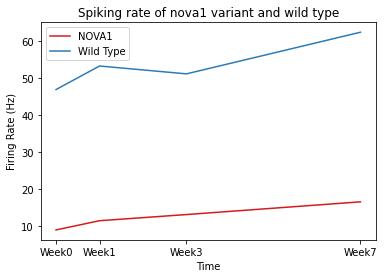

In [26]:
# plot the spiking rate for two groups
plt.plot([1, 2, 4, 8], sr_nova, c='#D7191C', label='NOVA1')
plt.plot([1, 2, 4, 8], sr_ctc, c='#2C7BB6', label='Wild Type')
plt.xticks(labels=['Week0','Week1','Week3','Week7'], ticks=[1, 2, 4, 8])
plt.ylabel('Firing Rate (Hz)')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title('Spiking rate of nova1 variant and wild type')

### Inter-Spike interval (ISI)

Then, we look at the inter-spike interval (ISI). ISI is normally influenced by three factors: intrinsic properties of the neurons, network interactions, and the nature of the input. Since all activities here are spontaneous activities, we mainly focus on the first two. 

In [8]:
def calculate_isi(file):
  """
  Caluculate inter-spike interval
  input:
    file: file loaded by h5py
  return: 
    inter-spike interval of all the channels in a 1D array
  """
  all_isi = []
  spikes = np.array(file['spikes'])
  for i in range(num_wells):
    isi = []
    for j in range(num_channels):
      spks = np.array(file[spikes[j, i]]).flatten()
      spks_diff = np.diff(spks).flatten()
      if len(spks_diff)>1:
        isi.append(spks_diff)
    if len(isi)>0:
      isi = np.hstack(isi)
      all_isi.append(isi)
  return np.hstack(all_isi)

# Calcualte ISI for all recordings
nova_isi = [calculate_isi(file) for file in nova_files]
ctc_isi = [calculate_isi(file) for file in ctc_files]

In the plot and the table below, it is clear that the NOVA1 variant group has higher variance than wild type group does. There are two possible explanations behind this result:
  1. NOVA1 has more diverse cell types, which means there are many different subpopulations of neurons that have various properties. 
  2. the excitatory and inhibitory inputs create a balance, leading to a fluctuating total drive

The table also shows that the wild type group has shorter ISI and more intervals(more spikes) than the NOVA1 group, confirming our previous conclusion that NOVA1 variant cortical organoid develops slower than the wild type cortical organoid.

Text(0.5, 0.98, 'Distribution of inter-spike intervals')

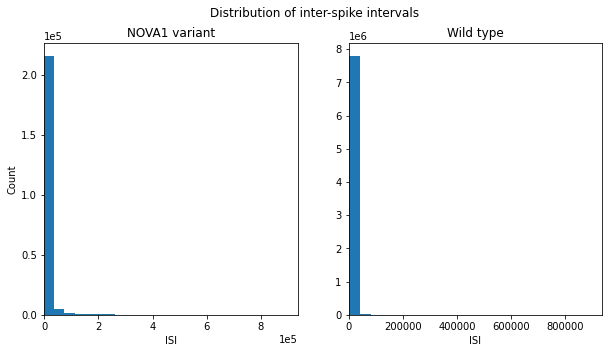

In [61]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(np.hstack(nova_isi),bins=50)
plt.title('NOVA1 variant')
plt.xlabel('ISI')
plt.ylabel('Count')
upper_lim = np.max([max(i) for i in nova_isi])/2
plt.xlim([0, upper_lim])
plt.ticklabel_format(axis="both", style="sci",scilimits=(0,0))
plt.subplot(1, 2, 2)
plt.hist(np.hstack(ctc_isi),bins=50)
plt.title('Wild type')
plt.xlabel('ISI')
plt.xlim([0, upper_lim])
plt.suptitle('Distribution of inter-spike intervals')

In [107]:
nova_isi_mean = np.mean(np.hstack(nova_isi))
ctc_isi_mean = np.mean(np.hstack(ctc_isi))
nova_isi_std = np.std(np.hstack(nova_isi))
ctc_isi_std = np.std(np.hstack(ctc_isi))
nova_isi_min = np.min(np.hstack(nova_isi))
ctc_isi_min = np.min(np.hstack(ctc_isi))
nova_isi_max = np.max(np.hstack(nova_isi))
ctc_isi_max = np.max(np.hstack(ctc_isi))

nova_mean_numspk = np.mean([len(i) for i in nova_isi])
ctc_mean_numspk = np.mean([len(i) for i in ctc_isi])


pd.DataFrame({'Mean':[nova_isi_mean, ctc_isi_mean],
              'Std': [nova_isi_std, ctc_isi_std],
              'Min':[nova_isi_min, ctc_isi_min],
              'Max':[nova_isi_max, ctc_isi_max],
              'Mean interval count':[nova_mean_numspk, ctc_mean_numspk]
              }, index=['NOVA1', 'Wild Type'])

,Mean,Std,Min,Max,Mean interval count
NOVA1,8443.815009,39158.165273,26.0,1873070.0,56355.50
Wild Type,742.263161,9850.596661,14.0,2046075.0,1956475.75


### Inter-Event Interval Coefficient of Variation (CV)



The inter-event interval coefficient of variation (CV) is a method to quantify network complexity. The CV is calculated by dividing the standard deviation of the inter-event interval by its mean. 

An event is defined using the following steps:
  1. the spiking rate is at least 1 spike/second
  2. the event is at least 1 second apart from the last event

Since only LFP amplitude data is available in the dataset, we do not consider the amplitude of each spike when defining events. 

After finding the event onset points that satisfy the criteria above, 0.5 seconds before and 2.5 seconds after each onset points are set as the start and the end points of each event because the events almost always diminish 2.5 seconds after the onsest.


In [110]:
def extract_events(well_id, channel_id, file):
  """
  Extract all the events onset point (t0) from the signals of one channel
  input:
    well_id: the ID of the well (0-11) on the MEA array
    channel_id: the ID of the channel (0-63) in the well
    file: file loaded by h5py
  return: 
    all the event onset points that satisfy the specified criteria
  """
  events_t0 = []
  spikes = np.array(file['spikes'])
  spks = np.array(file[spikes[channel_id, well_id]]).flatten()
  spks = (spks*fs_ds/fs_orig).astype('int') #convert index according to down-sampled sampling rate
  # faster way to check if spike rate is over 1Hz
  prev = spks[:-2]
  post = spks[2:] 
  diff = post - prev
  events_freq = prev[diff<event_len]
  # faster way to check if distance between event is greater than 1 second
  freq_prev = events_freq[:-1]
  freq_post = events_freq[1:]
  dist = freq_post - freq_prev
  t0_index = dist>(event_end+1)*fs_ds
  if sum(t0_index) > 0:
    events_t0 = np.insert(freq_post[t0_index], 0, freq_prev[0])
  return events_t0

def calculate_iei_cv(file):
  """
  Calculate inter-event interval(IEI) coefficient of variation (CV) in one recording
  input:
    file: file loaded by h5py
  output:
    all_cv: CV for all channels in the recording as a 1D list
  """
  all_cv = []
  #loop throught all channels
  for i in range(num_wells):
    iei = []
    for j in range(num_channels):
      events_t0 = extract_events(i, j, file) #extract event onsets
      iei.append(np.diff(events_t0).flatten()) #calculate IEI
    if len(iei)>0:
      iei = np.hstack(iei)
      # calculate CV
      iei_mean = np.nanmean(iei)
      iei_std = np.nanstd(iei)
      all_cv.append(iei_std/iei_mean)
    else:
      all_cv.append(np.nan)
  return all_cv

nova_cv = [calculate_iei_cv(file) for file in nova_files]
ctc_cv = [calculate_iei_cv(file) for file in ctc_files]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


The plot below shows the average CV for NOVA1 variant and Wild Type at each time point. It illustrates that the NOVA1 variant does have higher network complexity even during early development (0 to 7 weeks). 

It is slightly surprising to see that two groups all decrease in network complexity over time while it should increase according to previous findings for week 10 to 40 wild type cortical organoids (Trujillo et al., 2019). It might be the case that this decreasing trend is temporary and insignificant. But it is also possible that the network complexity increase again from week 7 to week 10 for the wild type organoid. As for the NOVA1 variant group, it is hard to conclude the network complexity development beyond week7 unless more data is provided.

(0.4, 1.0)

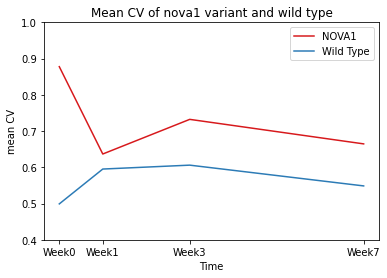

In [111]:
nova_mean_cv = [np.nanmean(cv) for cv in nova_cv]
ctc_mean_cv = [np.nanmean(cv) for cv in ctc_cv]

plt.plot([1, 2, 4, 8], nova_mean_cv, c='#D7191C', label='NOVA1')
plt.plot([1, 2, 4, 8], ctc_mean_cv, c='#2C7BB6', label='Wild Type')
plt.xticks(labels=['Week0','Week1','Week3','Week7'], ticks=[1, 2, 4, 8])
plt.ylabel('mean CV')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title('Mean CV of nova1 variant and wild type')
plt.ylim([0.4, 1])

### Spike Field Coherence (TODO)

In [15]:
import scipy.io as sio
from pylab import *

def extract_lfp_seg(lfp, events_t0):
  all_start = np.array(events_t0).astype('int') + int(event_start*fs_ds)
  all_end = np.array(events_t0).astype('int') + int(event_end*fs_ds)
  lfp_events = np.vstack([lfp[all_start[i]:all_end[i]] for i in range(len(events_t0)) if len(lfp[all_start[i]:all_end[i]])==event_len])
  return lfp_events

def extract_spks_seg(spks, num_events):
  spks_events = np.zeros((num_events, event_len))
  for i in range(num_events):
    shifted_spks = spks - i + int(event_start*fs_ds)
    shifted_spks = shifted_spks[np.logical_and(shifted_spks>=0, shifted_spks<=int(event_end*fs_ds))]
    spks_events[i, shifted_spks] = 1
  return spks_events
  
def calculate_sfc(well_id, channel_id, file):
  # https://mark-kramer.github.io/Case-Studies-Python/11.html
  events_t0 = extract_events(well_id, channel_id, file)
  N = event_len
  if len(events_t0)>0:
    lfp = np.array(file[np.array(file['LFP']).flatten()[well_id]])[channel_id, :]
    lfp_events = extract_lfp_seg(lfp, events_t0)
    num_events = lfp_events.shape[0]

    spikes = np.array(file['spikes'])
    spks = np.array(file[spikes[channel_id, well_id]]).flatten()
    spks = (spks*fs_ds/fs_orig).astype('int')
    spks_events = extract_spks_seg(spks, num_events)

    t = np.array(file['t_ds'])[0]                       
    K = num_events                                                                  
    dt = t[1]-t[0]                                     
    SYY = zeros(int(N/2+1))                      # Variable to store field spectrum.
    SNN = zeros(int(N/2+1))                      # Variable to store spike spectrum.
    SYN = zeros(int(N/2+1), dtype=complex)              # Variable to store cross spectrum.

    for k in arange(K):                                 # For each trial,
        yf = rfft((lfp_events[k,:]-mean(lfp_events[k,:])) *hanning(N))    # Hanning taper the field,
        nf = rfft((spks_events[k,:]-mean(spks_events[k,:])))                # ... but do not taper the spikes.
        SYY = SYY + (real(yf*conj(yf)))/K           # Field spectrum
        SNN = SNN + (real(nf*conj(nf)))/K           # Spike spectrum
        SYN = SYN + (yf*conj(nf))/K        # Cross spectrum
    cohr = real(SYN*conj(SYN)) / SYY / SNN              # Spike-field coherence
    return cohr
  return zeros(int(N/2+1))

def mean_well_sfc(file):
  all_sfc = []
  for well_id in range(num_wells):
    well_sfc = []
    for channel_id in range(num_channels):
      cohr = calculate_lfp(well_id, channel_id, file)
      well_sfc.append(cohr)
    all_sfc.append(np.nanmean(well_sfc))
  return all_sfc

In [ ]:

rerun_sfc = 0
if rerun_sfc:
  nova_sfc = []
  print('Calculating sfc of NOVA1 variant samples...')
  for file in tqdm(nova_files):
    nova_sfc.append(mean_well_sfc(file))

  ctc_sfc = []
  print('Calculating sfc of wild type samples...')
  for file in tqdm(ctc_files):
    ctc_sfc.append(mean_well_sfc(file))
    
  with open('/content/drive/My Drive/NOVA1_LFP/nova_sfc.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % sfc for sfc in nova_sfc)

  with open('/content/drive/My Drive/NOVA1_LFP/ctc_sfc.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % sfc for sfc in ctc_sfc)

  0%|          | 0/4 [00:00<?, ?it/s]

Calculating lfp of NOVA1 variant samples...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
  0%|          | 0/4 [00:00<?, ?it/s]

Calculating lfp of wild type samples...


100%|██████████| 4/4 [30:10<00:00, 452.64s/it]


In [16]:

rerun_sfc = 0
if not rerun_sfc:
  p = re.compile(r'\d+\.\d+')  # Compile a pattern to capture float values
  nova_sfc = []
  with open('/content/drive/My Drive/NOVA1_LFP/nova_sfc.txt', 'r') as filehandle:
    for line in filehandle.readlines():
      nova_sfc.append([float(i) for i in p.findall(line)])

  ctc_sfc = []
  with open('/content/drive/My Drive/NOVA1_LFP/ctc_sfc.txt', 'r') as filehandle:
    for line in filehandle.readlines():
      ctc_sfc.append([float(i) for i in p.findall(line)])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Distribution of Average Spike Field Coherence of Each Well at Each Week')

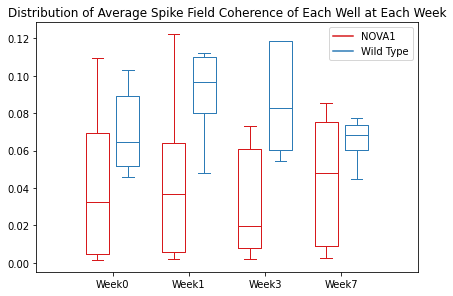

In [109]:
ticks = ['Week0','Week1','Week3','Week7']
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

nova_sfc = [list(np.array(sfc)[np.nonzero(sfc)[0]]) for sfc in nova_sfc]
ctc_sfc = [list(np.array(sfc)[np.nonzero(sfc)[0]]) for sfc in ctc_sfc]

plt.figure()
bpl = plt.boxplot(nova_sfc, positions=np.array(range(len(nova_sfc)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(ctc_sfc, positions=np.array(range(len(ctc_sfc)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='NOVA1')
plt.plot([], c='#2C7BB6', label='Wild Type')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.title('Distribution of Average Spike Field Coherence of Each Well at Each Week')

### PAC (TODO)

In [19]:
# define bandpass filters borrowed from UCSD COGS189WI21 A1 starter code
from scipy.signal import butter, sosfiltfilt, sosfreqz, hilbert
def butter_bandpass(lowcut, highcut, fs, order = 2):
  nyq = 0.5 * fs
  low = lowcut/nyq
  high = highcut/nyq
  sos = butter(order, [low, high], analog=False, btype='band', output='sos')
  return sos
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
  sos = butter_bandpass(lowcut, highcut, fs, order=order)
  y = sosfiltfilt(sos, data)
  return y

In [20]:
file=ctc_files[0]
spikes = np.array(file['spikes'])
lfp = np.array(file['LFP']).flatten()
# bandpass all 64 channels to get delta and gamma
well_id = 4
channel_id = 2
events_t0 = extract_events(well_id, channel_id, file)
lfp = np.array(file[np.array(file['LFP']).flatten()[well_id]])[channel_id, :]
lfp_segs = extract_lfp_seg(lfp, events_t0)
t = np.mean(lfp_segs, axis=0)
delta = butter_bandpass_filter(t, 0.1, 4, fs_ds)
gamma1 = butter_bandpass_filter(t, 100, 200, fs_ds)
gamma2 = butter_bandpass_filter(t, 200, 400, fs_ds)
#Get delta phase (From https://www.gaussianwaves.com/2017/04/extract-envelope-instantaneous-phase-frequency-hilbert-transform/)
z= hilbert(delta) #form the analytical signal
inst_amplitude = np.abs(z) #envelope extraction
delta_phase = np.unwrap(np.angle(z))#inst phase
#Get amplitude envolope of gamma bands, used square instead of square b.c. amplitude too small
gamma1_power = abs(hilbert(gamma1))
gamma2_power = abs(hilbert(gamma2))


Text(0.5, 1.0, 'Sample LFP trace during event')

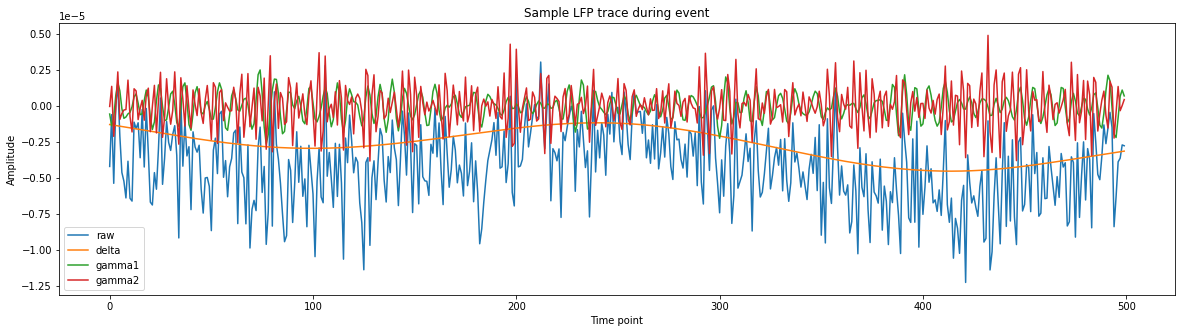

In [21]:
# plot sample lfp trace
begin = 1000
end = 1500
plt.figure(figsize=(20, 5))
plt.plot(t[begin:end], label='raw')
plt.plot(delta[begin:end], label='delta')
plt.plot(gamma1[begin:end], label='gamma1')
plt.plot(gamma2[begin:end], label='gamma2')
plt.legend()
plt.ylabel('Amplitude')
plt.xlabel('Time point')
plt.title('Sample LFP trace during event')

In [23]:
# Code from https://github.com/voytekresearch/Tutorials/blob/master/Spike%20Field%20Coherence%20Tutorial.ipynb
def circCorr(ang,line):
    n = len(ang)
    rxs = pearsonr(line,np.sin(ang))
    rxs = rxs[0]
    rxc = pearsonr(line,np.cos(ang))
    rxc = rxc[0]
    rcs = pearsonr(np.sin(ang),np.cos(ang))
    rcs = rcs[0]
    rho = np.sqrt((rxc**2 + rxs**2 - 2*rxc*rxs*rcs)/(1-rcs**2)) #r
    r_2 = rho**2 #r squared
    pval = 1- chi2.cdf(n*(rho**2),1)
    standard_error = np.sqrt((1-r_2)/(n-2))
    return rho, pval, r_2,standard_error

In [24]:
phase_data = delta_phase
amp_data = gamma2_power
print(circCorr(phase_data, amp_data))

(0.40550026801986105, 0.0, 0.16443046736417916, 0.016694579465631843)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


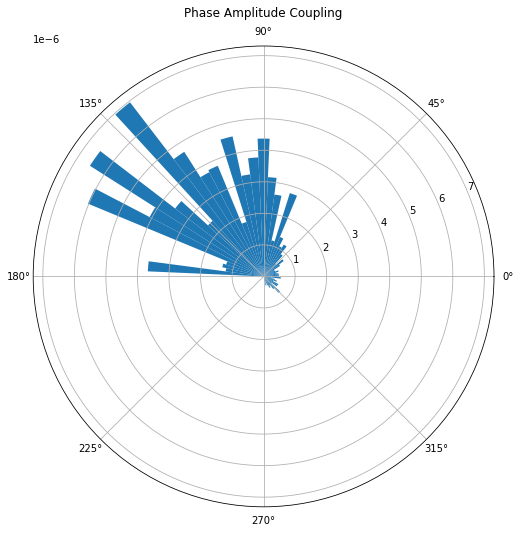

In [25]:
# Plot PAC example
bin_size = 5; 
bins = range(-180,180+bin_size,bin_size); 
bins = np.dot(bins, 0.0174532925);
amps = [];

#filling phase bins with amplitudes
for x in range(len(bins)-1):
    amps_above_lo_bound = np.where(phase_data >= bins[x])[0];
    amps_below_hi_bound = np.where(phase_data < bins[x+1])[0];
    amps_below_hi_bound = set(amps_below_hi_bound);
    amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if amp_val in amps_below_hi_bound]
    amps_in_this_bin = amp_data[amp_inds_in_this_bin];
    amps.append(np.nanmean(amps_in_this_bin));

bins = bins[:len(bins)-1];
#plotting figure;
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
ax.bar(bins, amps, width=bins[1]-bins[0], bottom=0.0)
plt.title('Phase Amplitude Coupling');

In [55]:
def calc_delta_phase(lfp, lower_bound=0.1, higher_bound=4):
  delta = butter_bandpass_filter(lfp, lower_bound, higher_bound, fs_ds)
  z= hilbert(delta) #form the analytical signal
  inst_amplitude = np.abs(z) #envelope extraction
  delta_phase = np.unwrap(np.angle(z))#inst phase
  return delta_phase

def calc_gamma_power(lfp, lower_bound=100, higher_bound=400, middle_cutoff=200):
  gamma1 = butter_bandpass_filter(lfp, lower_bound, middle_cutoff, fs_ds)
  gamma2 = butter_bandpass_filter(lfp, middle_cutoff, higher_bound, fs_ds)
  gamma1_power = abs(hilbert(gamma1))
  gamma2_power = abs(hilbert(gamma2))
  return gamma1_power, gamma2_power

def get_coupling_phase(phase_data, amp_data, bin_size = 18): 
  bins = range(-180,180+bin_size,bin_size)
  bins = np.dot(bins, 0.0174532925)
  amps = []
  #filling phase bins with amplitudes
  for x in range(len(bins)-1):
      amps_above_lo_bound = np.where(phase_data >= bins[x])[0];
      amps_below_hi_bound = np.where(phase_data < bins[x+1])[0];
      amps_below_hi_bound = set(amps_below_hi_bound);
      amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if amp_val in amps_below_hi_bound]
      amps_in_this_bin = amp_data[amp_inds_in_this_bin];
      amps.append(np.nanmean(amps_in_this_bin));
  return np.array(amps)

def get_all_pac(file, pval_cutoff = 0.001):
  corr_gamma1 = []
  corr_gamma2 = []
  gamma1_coupling = []
  gamma2_coupling = []
  for well_id in tqdm(range(num_wells)):
    channel_corr1 = []
    channel_corr2 = []
    channel_coupling1 = []
    channel_coupling2 = []
    for channel_id in range(num_channels):
      events_t0 = extract_events(well_id, channel_id, file)
      if len(events_t0)>0:
        lfp = np.array(file[np.array(file['LFP']).flatten()[well_id]])[channel_id, :]
        lfp_segs = extract_lfp_seg(lfp, events_t0)
        lfp = np.nanmean(lfp_segs, axis=0)
        delta_phase = calc_delta_phase(lfp)
        gamma1_power, gamma2_power = calc_gamma_power(lfp)
        corr1, pval1, _, _ = circCorr(delta_phase, gamma1_power)
        corr2, pval2, _, _ = circCorr(delta_phase, gamma2_power)
        amps1 = get_coupling_phase(delta_phase, gamma1_power)
        amps2 = get_coupling_phase(delta_phase, gamma2_power)
        if pval1 < pval_cutoff:
          channel_corr1.append(corr1)
          channel_coupling1.append(amps1)
        if pval2 < pval_cutoff:
          channel_corr2.append(corr2)
          channel_coupling2.append(amps2)
    corr_gamma1.append(np.array(channel_corr1))
    corr_gamma2.append(np.array(channel_corr2))
    if len(channel_coupling1)!=0:
      gamma1_coupling.append(channel_coupling1)
    if len(channel_coupling2)!=0:
      gamma2_coupling.append(channel_coupling2)
  flat_corr1 = np.hstack(corr_gamma1)
  flat_corr2 = np.hstack(corr_gamma2)
  mean_coupling1 = np.nanmean(np.vstack(gamma1_coupling), axis=0)
  mean_coupling2 = np.nanmean(np.vstack(gamma2_coupling), axis=0)
  corr_stats = {'gamma1_mean':np.nanmean(flat_corr1), 'gamma1_std':np.nanstd(flat_corr1), 'gamma2_mean':np.nanmean(flat_corr2), 'gamma2_std':np.nanstd(flat_corr2)}
  return corr_stats, list(mean_coupling1), list(mean_coupling2)

In [60]:
time_points = ['week0', 'week1', 'week3', 'week7']
rerun_pac = 0
if rerun_pac:
  ctc_pac = {}
  for i in range(len(ctc_files)):
    pac = {}
    print('Calculating PAC for Wild Type File #%d'%i)
    corr_stats, mean_coupling1, mean_coupling2 = get_all_pac(ctc_files[i])
    pac['stats'] = corr_stats
    pac['gamma1_mean'] = mean_coupling1
    pac['gamma2_mean'] = mean_coupling2
    ctc_pac[time_points[i]] = pac
  with open('/content/drive/My Drive/NOVA1_LFP/ctc_pac.json', 'w') as outfile:  
    json.dump(ctc_pac, outfile) 




  0%|          | 0/12 [00:00<?, ?it/s]

Calculating PAC for Wild Type File #0





  8%|▊         | 1/12 [00:00<00:02,  4.31it/s]


 25%|██▌       | 3/12 [00:00<00:01,  5.56it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice



 42%|████▏     | 5/12 [01:10<01:14, 10.60s/it]


 50%|█████     | 6/12 [02:10<02:33, 25.61s/it]


 58%|█████▊    | 7/12 [03:00<02:44, 32.80s/it]


 67%|██████▋   | 8/12 [04:01<02:45, 41.33s/it]


 75%|███████▌  | 9/12 [05:02<02:21, 47.15s/it]


 83%|████████▎ | 10/12 [06:05<01:43, 51.97s/it]


 92%|█████████▏| 11/12 [07:05<00:54, 54.38s/it]


100%|██████████| 12/12 [08:07<00:00, 40.61s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice



  0%|          | 0/12 [00:00<?, ?it/s]


 17%|█▋        | 2/12 [00:00<00:00, 18.18it/s]

Calculating PAC for Wild Type File #1





 33%|███▎      | 4/12 [00:00<00:00, 17.73it/s]


 42%|████▏     | 5/12 [01:02<02:10, 18.63s/it]


 50%|█████     | 6/12 [02:02<03:06, 31.16s/it]


 58%|█████▊    | 7/12 [02:53<03:05, 37.05s/it]


 67%|██████▋   | 8/12 [04:02<03:06, 46.57s/it]


 75%|███████▌  | 9/12 [05:02<02:32, 50.83s/it]


 83%|████████▎ | 10/12 [06:06<01:49, 54.58s/it]


 92%|█████████▏| 11/12 [07:08<00:56, 56.73s/it]


100%|██████████| 12/12 [08:12<00:00, 41.01s/it]



  0%|          | 0/12 [00:00<?, ?it/s]


 17%|█▋        | 2/12 [00:00<00:00, 16.94it/s]

Calculating PAC for Wild Type File #2





 33%|███▎      | 4/12 [00:00<00:00, 16.92it/s]


 42%|████▏     | 5/12 [01:00<02:07, 18.18s/it]


 50%|█████     | 6/12 [01:59<03:01, 30.30s/it]


 58%|█████▊    | 7/12 [02:48<02:59, 35.89s/it]


 67%|██████▋   | 8/12 [03:48<02:52, 43.22s/it]


 75%|███████▌  | 9/12 [04:48<02:25, 48.36s/it]


 83%|████████▎ | 10/12 [05:55<01:47, 53.93s/it]


 92%|█████████▏| 11/12 [06:56<00:55, 55.90s/it]


100%|██████████| 12/12 [07:56<00:00, 39.71s/it]



  0%|          | 0/12 [00:00<?, ?it/s]


 17%|█▋        | 2/12 [00:00<00:00, 18.22it/s]

Calculating PAC for Wild Type File #3





 33%|███▎      | 4/12 [00:00<00:00, 17.80it/s]


 42%|████▏     | 5/12 [01:00<02:07, 18.22s/it]


 50%|█████     | 6/12 [01:53<02:51, 28.61s/it]


 58%|█████▊    | 7/12 [02:43<02:55, 35.07s/it]


 67%|██████▋   | 8/12 [03:44<02:50, 42.65s/it]


 75%|███████▌  | 9/12 [04:46<02:25, 48.41s/it]


 83%|████████▎ | 10/12 [05:46<01:44, 52.00s/it]


 92%|█████████▏| 11/12 [06:46<00:54, 54.50s/it]


100%|██████████| 12/12 [07:52<00:00, 39.41s/it]


In [58]:
if rerun_pac:
  nova_pac = {}
  for i in range(len(nova_files)):
    pac = {}
    print('Calculating PAC for NOVA1 File #%d'%i)
    corr_stats, mean_coupling1, mean_coupling2 = get_all_pac(nova_files[i])
    pac['stats'] = corr_stats
    pac['gamma1_mean'] = mean_coupling1
    pac['gamma2_mean'] = mean_coupling2
    nova_pac[time_points[i]] = pac
  with open('/content/drive/My Drive/NOVA1_LFP/nova_pac.json', 'w') as outfile:  
    json.dump(nova_pac, outfile) 




  0%|          | 0/12 [00:00<?, ?it/s]

Calculating PAC for NOVA1 File #0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice



  8%|▊         | 1/12 [00:03<00:43,  3.95s/it]


 17%|█▋        | 2/12 [00:08<00:41,  4.14s/it]


 25%|██▌       | 3/12 [00:31<01:28,  9.80s/it]


 33%|███▎      | 4/12 [00:48<01:34, 11.85s/it]


 42%|████▏     | 5/12 [00:51<01:04,  9.20s/it]


 50%|█████     | 6/12 [00:52<00:40,  6.72s/it]


 58%|█████▊    | 7/12 [01:09<00:50, 10.06s/it]


 67%|██████▋   | 8/12 [01:41<01:05, 16.41s/it]


 75%|███████▌  | 9/12 [01:43<00:36, 12.20s/it]


 83%|████████▎ | 10/12 [01:44<00:17,  8.82s/it]


 92%|█████████▏| 11/12 [02:06<00:12, 12.81s/it]


100%|██████████| 12/12 [02:13<00:00, 11.16s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice



  0%|          | 0/12 [00:00<?, ?it/s]

Calculating PAC for NOVA1 File #1





  8%|▊         | 1/12 [00:01<00:12,  1.16s/it]


 17%|█▋        | 2/12 [00:02<00:13,  1.32s/it]


 25%|██▌       | 3/12 [00:19<00:54,  6.01s/it]


 33%|███▎      | 4/12 [00:35<01:10,  8.77s/it]


 42%|████▏     | 5/12 [00:36<00:46,  6.62s/it]


 50%|█████     | 6/12 [00:37<00:29,  4.96s/it]


 58%|█████▊    | 7/12 [00:50<00:36,  7.21s/it]


 67%|██████▋   | 8/12 [01:08<00:41, 10.47s/it]


 75%|███████▌  | 9/12 [01:09<00:23,  7.82s/it]


 83%|████████▎ | 10/12 [01:10<00:11,  5.81s/it]


 92%|█████████▏| 11/12 [01:26<00:08,  8.74s/it]


100%|██████████| 12/12 [01:34<00:00,  7.85s/it]



  0%|          | 0/12 [00:00<?, ?it/s]

Calculating PAC for NOVA1 File #2





  8%|▊         | 1/12 [00:03<00:34,  3.17s/it]


 17%|█▋        | 2/12 [00:05<00:29,  2.97s/it]


 25%|██▌       | 3/12 [00:29<01:22,  9.21s/it]


 33%|███▎      | 4/12 [00:46<01:31, 11.44s/it]


 42%|████▏     | 5/12 [00:48<01:00,  8.70s/it]


 50%|█████     | 6/12 [00:49<00:38,  6.36s/it]


 58%|█████▊    | 7/12 [01:12<00:57, 11.53s/it]


 67%|██████▋   | 8/12 [01:38<01:03, 15.89s/it]


 75%|███████▌  | 9/12 [01:42<00:36, 12.24s/it]


 92%|█████████▏| 11/12 [01:59<00:11, 11.06s/it]


100%|██████████| 12/12 [02:08<00:00, 10.72s/it]



  0%|          | 0/12 [00:00<?, ?it/s]

Calculating PAC for NOVA1 File #3





  8%|▊         | 1/12 [00:04<00:51,  4.64s/it]


 17%|█▋        | 2/12 [00:12<00:55,  5.58s/it]


 25%|██▌       | 3/12 [00:37<01:41, 11.31s/it]


 33%|███▎      | 4/12 [01:03<02:06, 15.78s/it]


 50%|█████     | 6/12 [01:04<01:07, 11.19s/it]


 58%|█████▊    | 7/12 [01:24<01:08, 13.76s/it]


 67%|██████▋   | 8/12 [01:46<01:05, 16.42s/it]


 75%|███████▌  | 9/12 [01:49<00:36, 12.20s/it]


 83%|████████▎ | 10/12 [01:49<00:17,  8.62s/it]


 92%|█████████▏| 11/12 [02:06<00:11, 11.26s/it]


100%|██████████| 12/12 [02:15<00:00, 11.33s/it]


In [64]:
rerun_pac = 0
if not rerun_pac:
  with open('/content/drive/My Drive/NOVA1_LFP/nova_pac.json') as f:
    nova_pac = json.load(f)
  with open('/content/drive/My Drive/NOVA1_LFP/ctc_pac.json') as f:
    ctc_pac = json.load(f)

In [65]:
def extract_mean_std_pac(pac_dict):
  gamma1_mean = []
  gamma2_mean = []
  gamma1_std = []
  gamma2_std = []
  for k in pac_dict.keys():
    gamma1_mean.append(pac_dict[k]['stats']['gamma1_mean'])
    gamma2_mean.append(pac_dict[k]['stats']['gamma2_mean'])
    gamma1_std.append(pac_dict[k]['stats']['gamma1_std'])
    gamma2_std.append(pac_dict[k]['stats']['gamma2_std'])
  return gamma1_mean, gamma1_std, gamma2_mean, gamma2_std

def extract_mean_coupling(pac_dict):
  gamma1_cp = []
  gamma2_cp = []
  for k in pac_dict.keys():
    gamma1_cp.append(pac_dict[k]['gamma1_mean'])
    gamma2_cp.append(pac_dict[k]['gamma2_mean'])
  return gamma1_cp, gamma2_cp

In [67]:
nova_gamma1_mean, nova_gamma1_std, nova_gamma2_mean, nova_gamma2_std = extract_mean_std_pac(nova_pac)
ctc_gamma1_mean, ctc_gamma1_std, ctc_gamma2_mean, ctc_gamma2_std = extract_mean_std_pac(ctc_pac)

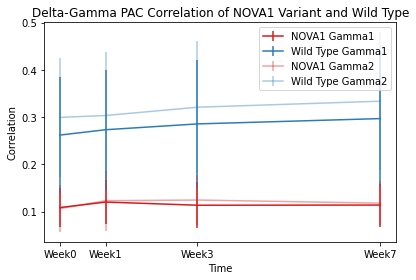

In [77]:
plt.errorbar([1, 2, 4, 8], nova_gamma1_mean, yerr=nova_gamma1_std, c='#D7191C', label='NOVA1 Gamma1')
plt.errorbar([1, 2, 4, 8], ctc_gamma1_mean, yerr=ctc_gamma1_std, c='#2C7BB6', label='Wild Type Gamma1')
plt.errorbar([1, 2, 4, 8], nova_gamma2_mean, yerr=nova_gamma2_std, c='#D7191C', alpha=0.4, label='NOVA1 Gamma2')
plt.errorbar([1, 2, 4, 8], ctc_gamma2_mean, yerr=ctc_gamma2_std, c='#2C7BB6', alpha=0.4, label='Wild Type Gamma2')
plt.xticks(labels=['Week0','Week1','Week3','Week7'], ticks=[1, 2, 4, 8])
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.legend(loc='best')
plt.title('Delta-Gamma PAC Correlation of NOVA1 Variant and Wild Type')
plt.tight_layout()

In [93]:
nova_gamma1_cp, nova_gamma2_cp = extract_mean_coupling(nova_pac)
ctc_gamma1_cp, ctc_gamma2_cp = extract_mean_coupling(ctc_pac)
nova_g1cp_mean = np.nanmean(nova_gamma1_cp, axis=0)
nova_g2cp_mean = np.nanmean(nova_gamma2_cp, axis=0)
ctc_g1cp_mean = np.nanmean(ctc_gamma1_cp, axis=0)
ctc_g2cp_mean = np.nanmean(ctc_gamma2_cp, axis=0)

Text(0.5, 0.98, 'Mean Gamma Amplitude in Each Delta Phase Bin')

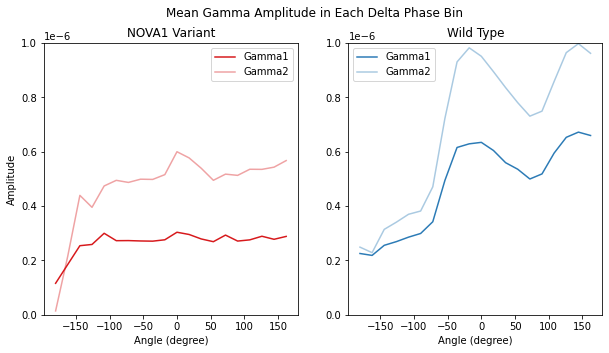

In [105]:
bin_size = 18
x_ticks = range(-180,180,bin_size)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x_ticks, nova_g1cp_mean, c='#D7191C', label='Gamma1')
plt.plot(x_ticks, nova_g2cp_mean, c='#D7191C', alpha=0.4, label='Gamma2')
plt.xlabel('Angle (degree)')
plt.ylabel('Amplitude')
plt.ylim([0,1e-6])
plt.title('NOVA1 Variant')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(x_ticks, ctc_g1cp_mean, c='#2C7BB6', label='Gamma1')
plt.plot(x_ticks, ctc_g2cp_mean, c='#2C7BB6', alpha=0.4, label='Gamma2')
plt.xlabel('Angle (degree)')
plt.ylim([0,1e-6])
plt.title('Wild Type')
plt.legend(loc='best')
plt.suptitle('Mean Gamma Amplitude in Each Delta Phase Bin')